## Baseline

### Imports

In [2]:
!pip install datasets
!pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-caoku5fa
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-caoku5fa
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done


In [3]:
import torch
from torch import nn
from datasets import load_dataset
from diffusers import StableDiffusionPipeline
from torchvision import transforms
from skimage.metrics import structural_similarity as ssim
import numpy as np
from PIL import Image
import clip
from tqdm import tqdm

### Data preparation

In [4]:
num_samples = 10
dataset = load_dataset("vinesmsuic/GenAI-Bench_image_edition_processed")
dataset = dataset['train']

def get_preferred_image(row):
    if row['vote_type'] == 'rightvote':
        return row['right_output_image']
    else:
        return row['left_output_image']

def is_valid_size(image, size=(512, 512)):
    """Check if image has the required dimensions"""
    return image.size == size

valid_indices = []
for idx, item in enumerate(dataset):
    source_img = item['source_image']
    preferred_img = get_preferred_image(item)

    if is_valid_size(source_img) and is_valid_size(preferred_img):
        valid_indices.append(idx)

dataset = dataset.select(valid_indices)
dataset = dataset.select(range(num_samples))

dataset = {
    'source_image': dataset['source_image'],
    'target_prompt': dataset['target_prompt'],
    'source_prompt': dataset['source_prompt'],
    'instruct_prompt': dataset['instruct_prompt'],
    'target_image': [get_preferred_image(row) for row in dataset],
    'vote_type': dataset['vote_type'],
    'preference': dataset['preferences']
}

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


### Model Setup

In [293]:
model_name = "CompVis/stable-diffusion-v1-4"
stable_diffusion = StableDiffusionPipeline.from_pretrained(
    model_name,
    torch_dtype=torch.float16
).to("cuda")

clip_model, clip_preprocess = clip.load("ViT-B/32", device="cuda")

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Exception ignored in: <function tqdm.__del__ at 0x7ebeaa6bfa60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/tqdm/std.py", line 1148, in __del__
    self.close()
  File "/usr/local/lib/python3.11/dist-packages/tqdm/notebook.py", line 282, in close
    self.disp(bar_style='success', check_delay=False)
    ^^^^^^^^^
AttributeError: 'tqdm' object has no attribute 'disp'
100%|███████████████████████████████████████| 338M/338M [00:07<00:00, 46.3MiB/s]


### Baseline Generation and Evaluation

In [ ]:
generated_images = []

for prompt, src_image in tqdm(zip(dataset['target_prompt'], dataset['source_image']), total=len(dataset['target_prompt'])):
    images = stable_diffusion(
        prompt,
        heihht=src_image.size[0],
        width=src_image.size[1],
        num_inference_steps=50,
        guidance_scale=7.5,
        progress_bar=False).images
    generated_images.extend(images)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:07<01:09,  7.69s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:15<01:01,  7.68s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 30%|███       | 3/10 [00:23<00:54,  7.73s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 40%|████      | 4/10 [00:31<00:46,  7.78s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 50%|█████     | 5/10 [00:38<00:39,  7.84s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 60%|██████    | 6/10 [00:46<00:31,  7.91s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 70%|███████   | 7/10 [00:55<00:23,  7.97s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 80%|████████  | 8/10 [01:03<00:15,  7.98s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 90%|█████████ | 9/10 [01:11<00:07,  7.96s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 10/10 [01:18<00:00,  7.89s/it]


In [289]:
def compute_ssim(img1, img2):
    """Compute SSIM between two images"""
    # Convert PIL images to numpy arrays
    img1_np = np.array(img1.convert('L'))
    img2_np = np.array(img2.convert('L'))

    return ssim(img1_np, img2_np)

In [290]:
def compute_clip_similarity_img2img(clip_model, clip_preprocess, img1, img2):
    """Compute CLIP similarity between images or image and text"""
    # Image to image clip similarity
    img1_processed = clip_preprocess(img1).unsqueeze(0).to("cuda")
    img2_processed = clip_preprocess(img2).unsqueeze(0).to("cuda")

    with torch.no_grad():
        img1_features = clip_model.encode_image(img1_processed)
        img2_features = clip_model.encode_image(img2_processed)
        similarity = torch.cosine_similarity(img1_features, img2_features).item()

    return similarity

def compute_clip_similarity_img2text(clip_model, clip_preprocess, img, text):
    # Image to text clip similarity
    img_processed = clip_preprocess(img).unsqueeze(0).to("cuda")
    text_tokens = clip.tokenize([text]).to("cuda")
    with torch.no_grad():
        img_features = clip_model.encode_image(img_processed)
        text_features = clip_model.encode_text(text_tokens)
        similarity = torch.cosine_similarity(img_features, text_features).item()

    return similarity

In [ ]:
metrics = {
    'ssim_scores': [],
    'clip_img2img_target_scores': [],
    'clip_img2img_source_scores': [],
    'clip_img2text_target_scores': [],
    'clip_img2text_source_scores': [],
}

for gen_img, source_img, source_prompt, target_img, target_prompt in zip(generated_images, dataset['source_image'], dataset['source_prompt'], dataset['target_image'], dataset['target_prompt']):
    # Compute SSIM
    ssim_score = compute_ssim(gen_img, target_img)
    metrics['ssim_scores'].append(ssim_score)

    # Compute CLIP similarities
    metrics['clip_img2img_target_scores'].append(compute_clip_similarity_img2img(clip_model, clip_preprocess, gen_img, target_img))
    metrics['clip_img2img_source_scores'].append(compute_clip_similarity_img2img(clip_model, clip_preprocess, gen_img, source_img))
    metrics['clip_img2text_target_scores'].append(compute_clip_similarity_img2text(clip_model, clip_preprocess, gen_img, target_prompt))
    metrics['clip_img2text_source_scores'].append(compute_clip_similarity_img2text(clip_model, clip_preprocess, gen_img, source_prompt))

In [ ]:
for metric_name, scores in metrics.items():
    mean_score = np.mean(scores)
    std_score = np.std(scores)
    print(f"{metric_name}:\t{mean_score:.4f} (±{std_score:.4f})")

ssim_scores:	0.1863 (±0.0703)
clip_img2img_target_scores:	0.7277 (±0.1424)
clip_img2img_source_scores:	0.6639 (±0.1376)
clip_img2text_target_scores:	0.3234 (±0.0260)
clip_img2text_source_scores:	0.2908 (±0.0249)


## DDIM Inversion

### Implementation

In [264]:
import torch
from diffusers import StableDiffusionPipeline, DDIMScheduler
from PIL import Image
import torch.nn.functional as F
from tqdm.auto import tqdm

class DDIMInversion:
    def __init__(self):
        pass

    def preprocess_image(self, image):
        """Preprocess image for VAE input"""
        if isinstance(image, Image.Image):
            image = image.resize((512, 512))
            image = torch.from_numpy(np.array(image)).float() / 127.5 - 1
            image = image.to(dtype=torch.float16)
            image = image.permute(2, 0, 1).unsqueeze(0).to("cuda")
        return image

    def encode_images(self, pipeline, images):
        """Encode images to latent space"""
        with torch.no_grad():
            latents = pipeline.vae.encode(images).latent_dist.sample()
            latents = latents * 0.18215
        return latents

    def ddim_inversion(self, pipeline, image, prompt, num_inference_steps=200, num_real_steps=80):
        """Perform DDIM inversion to get latents"""
        pipeline.scheduler.set_timesteps(num_inference_steps)

        # Preprocess and encode image
        image = self.preprocess_image(image)
        latents = [self.encode_images(pipeline, image)]

        # Get text embeddings
        text_embeddings = pipeline._encode_prompt(
            prompt,
            device="cuda",
            num_images_per_prompt=1,
            do_classifier_free_guidance=True
        )

        # Initialize timesteps
        timesteps = pipeline.scheduler.timesteps.flip(0)

        # DDIM inversion
        print("Performing DDIM inversion...")
        for i in tqdm(np.arange(1, num_real_steps)):
            # Expand latents for classifier free guidance
            t = timesteps[i]
            latent_model_input = torch.cat([latents[-1]] * 2)

            # Predict noise
            with torch.no_grad():
                noise_pred = pipeline.unet(
                    latent_model_input,
                    t,
                    encoder_hidden_states=text_embeddings
                ).sample

            # Perform guidance
            noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
            noise_pred = noise_pred_uncond + 7.5 * (noise_pred_text - noise_pred_uncond)

            current_t = timesteps[i-1] # t
            next_t = t  # min(999, t.item() + (1000//num_inference_steps)) # t+1
            alpha_t = pipeline.scheduler.alphas_cumprod[current_t]
            alpha_t_next = pipeline.scheduler.alphas_cumprod[next_t]

            # DDIM reverse step
            latents += [(latents[-1] - (1 - alpha_t).sqrt() * noise_pred) * (alpha_t_next.sqrt() / alpha_t.sqrt()) + (
                1 - alpha_t_next
            ).sqrt() * noise_pred]

        return latents

    def regenerate_with_target(self, pipeline, latents, target_prompt, num_inference_steps=200, num_real_steps=50):
        """Generate new image from inverted latents using target prompt"""
        latents = latents[-1]
        pipeline.scheduler.set_timesteps(num_inference_steps)

        # Get text embeddings for target prompt
        text_embeddings = pipeline._encode_prompt(
            target_prompt,
            device="cuda",
            num_images_per_prompt=1,
            do_classifier_free_guidance=True
        )

        # Generation loop
        print("Generating with target prompt...")
        for t in tqdm(list(pipeline.scheduler.timesteps)[-num_real_steps-1:-2:]):
            # Expand latents for classifier free guidance
            latent_model_input = torch.cat([latents] * 2)

            # Predict noise
            with torch.no_grad():
                noise_pred = pipeline.unet(
                    latent_model_input,
                    t,
                    encoder_hidden_states=text_embeddings
                ).sample

            # Perform guidance
            noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
            noise_pred = noise_pred_uncond + 7.5 * (noise_pred_text - noise_pred_uncond)

            # DDIM step
            latents = pipeline.scheduler.step(
                noise_pred,
                t,
                latents
            ).prev_sample

        # Decode latents to image
        with torch.no_grad():
            latents = 1 / 0.18215 * latents
            image = pipeline.vae.decode(latents).sample

        # Postprocess image
        image = (image / 2 + 0.5).clamp(0, 1)
        image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
        image = (image * 255).round().astype("uint8")
        image = Image.fromarray(image[0])

        return image

# Example usage
def edit_image(pipeline, source_image, source_prompt, target_prompt, num_inference_steps=1000, num_real_steps=500):
    """Edit image using DDIM inversion and target prompt"""
    # Initialize model
    ddim_inv = DDIMInversion()

    # Perform inversion
    inverted_latents = ddim_inv.ddim_inversion(pipeline, source_image, source_prompt, num_inference_steps=num_inference_steps, num_real_steps=num_real_steps)

    # Generate with target prompt
    edited_image = ddim_inv.regenerate_with_target(pipeline, inverted_latents, target_prompt, num_inference_steps=num_inference_steps, num_real_steps=num_real_steps)

    return edited_image

Cat sleeping on top of a suitcase that is resting on top of a table.
Cat sleeping on top of a suitcase that is resting on top of a table, licking its nose.


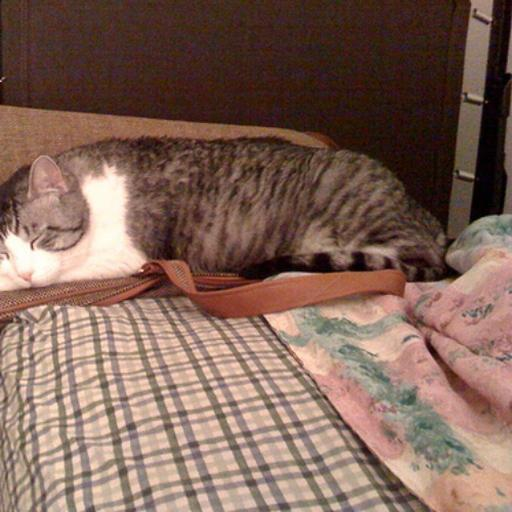

In [307]:
idx = 7
source_image  = dataset['source_image'][idx]
target_image  = dataset['target_image'][idx]
source_prompt = dataset['source_prompt'][idx]
target_prompt = dataset['target_prompt'][idx]

print(source_prompt)
print(target_prompt)
source_image

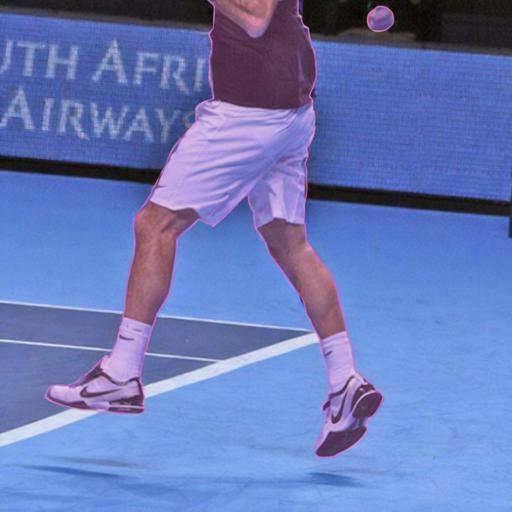

In [305]:
target_image

In [285]:
# model_name = "CompVis/stable-diffusion-v1-4"
# stable_diffusion = StableDiffusionPipeline.from_pretrained(
#     model_name,
#     torch_dtype=torch.float16
# ).to("cuda")

# stable_diffusion.vae.requires_grad_(False)
# stable_diffusion.text_encoder.requires_grad_(False)
# stable_diffusion.unet.requires_grad_(False)
# None

In [286]:
gen_image = edit_image(stable_diffusion, source_image, source_prompt, target_prompt, num_inference_steps=500, num_real_steps=300)

Performing DDIM inversion...


  0%|          | 0/299 [00:00<?, ?it/s]

Generating with target prompt...


  0%|          | 0/299 [00:00<?, ?it/s]

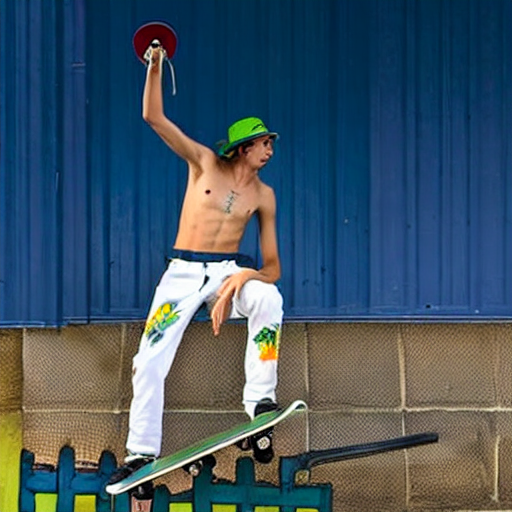

In [287]:
gen_image

In [311]:
generated_images = []

for source_prompt, target_prompt, src_image in tqdm(zip(dataset['source_prompt'], dataset['target_prompt'], dataset['source_image']), total=len(dataset['target_prompt'])):
    gen_image = edit_image(stable_diffusion, src_image, source_prompt, target_prompt, num_inference_steps=500, num_real_steps=300)
    generated_images.append(gen_image)

  0%|          | 0/10 [00:00<?, ?it/s]

Performing DDIM inversion...


/usr/local/lib/python3.11/dist-packages/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion.py:308: FutureWarning: `_encode_prompt()` is deprecated and it will be removed in a future version. Use `encode_prompt()` instead. Also, be aware that the output format changed from a concatenated tensor to a tuple.
  deprecate("_encode_prompt()", "1.0.0", deprecation_message, standard_warn=False)


  0%|          | 0/299 [00:00<?, ?it/s]

Generating with target prompt...


  0%|          | 0/299 [00:00<?, ?it/s]

Performing DDIM inversion...


  0%|          | 0/299 [00:00<?, ?it/s]

Generating with target prompt...


  0%|          | 0/299 [00:00<?, ?it/s]

Performing DDIM inversion...


  0%|          | 0/299 [00:00<?, ?it/s]

Generating with target prompt...


  0%|          | 0/299 [00:00<?, ?it/s]

Performing DDIM inversion...


  0%|          | 0/299 [00:00<?, ?it/s]

Generating with target prompt...


  0%|          | 0/299 [00:00<?, ?it/s]

Performing DDIM inversion...


  0%|          | 0/299 [00:00<?, ?it/s]

Generating with target prompt...


  0%|          | 0/299 [00:00<?, ?it/s]

Performing DDIM inversion...


  0%|          | 0/299 [00:00<?, ?it/s]

Generating with target prompt...


  0%|          | 0/299 [00:00<?, ?it/s]

Performing DDIM inversion...


  0%|          | 0/299 [00:00<?, ?it/s]

Generating with target prompt...


  0%|          | 0/299 [00:00<?, ?it/s]

Performing DDIM inversion...


  0%|          | 0/299 [00:00<?, ?it/s]

Generating with target prompt...


  0%|          | 0/299 [00:00<?, ?it/s]

Performing DDIM inversion...


  0%|          | 0/299 [00:00<?, ?it/s]

Generating with target prompt...


  0%|          | 0/299 [00:00<?, ?it/s]

Performing DDIM inversion...


  0%|          | 0/299 [00:00<?, ?it/s]

Generating with target prompt...


  0%|          | 0/299 [00:00<?, ?it/s]

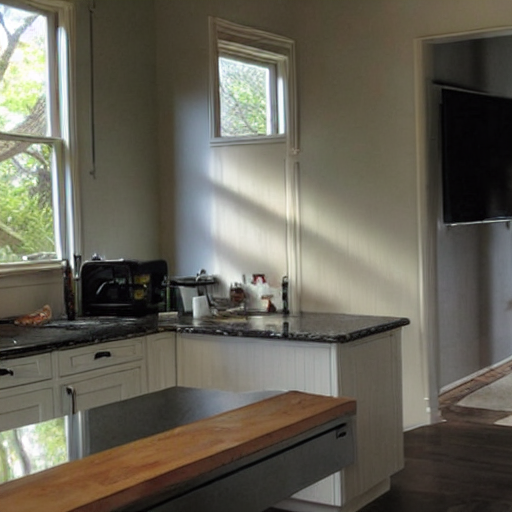

In [332]:
generated_images[3]

In [313]:
metrics = {
    'ssim_scores': [],
    'clip_img2img_target_scores': [],
    'clip_img2img_source_scores': [],
    'clip_img2text_target_scores': [],
    'clip_img2text_source_scores': [],
}

for gen_img, source_img, source_prompt, target_img, target_prompt in zip(generated_images, dataset['source_image'], dataset['source_prompt'], dataset['target_image'], dataset['target_prompt']):
    # Compute SSIM
    ssim_score = compute_ssim(gen_img, target_img)
    metrics['ssim_scores'].append(ssim_score)

    # Compute CLIP similarities
    metrics['clip_img2img_target_scores'].append(compute_clip_similarity_img2img(clip_model, clip_preprocess, gen_img, target_img))
    metrics['clip_img2img_source_scores'].append(compute_clip_similarity_img2img(clip_model, clip_preprocess, gen_img, source_img))
    metrics['clip_img2text_target_scores'].append(compute_clip_similarity_img2text(clip_model, clip_preprocess, gen_img, target_prompt))
    metrics['clip_img2text_source_scores'].append(compute_clip_similarity_img2text(clip_model, clip_preprocess, gen_img, source_prompt))

In [314]:
for metric_name, scores in metrics.items():
    mean_score = np.mean(scores)
    std_score = np.std(scores)
    print(f"{metric_name}:\t{mean_score:.4f} (±{std_score:.4f})")

ssim_scores:	0.5590 (±0.1139)
clip_img2img_target_scores:	0.7703 (±0.0667)
clip_img2img_source_scores:	0.7597 (±0.0827)
clip_img2text_target_scores:	0.2660 (±0.0560)
clip_img2text_source_scores:	0.2340 (±0.0479)
